
# インスタンスセグメンテーションの可視化 

このノートブックは[こちら](https://pytorch.org/vision/main/auto_examples/others/plot_visualization_utils.html#instance-seg-output)を必要な部分だけ残して編集したもの
<div class="alert alert-info"><h4>Note</h4><p>Try on [collab](https://colab.research.google.com/github/pytorch/vision/blob/gh-pages/main/_generated_ipynb_notebooks/plot_visualization_utils.ipynb)
    or `go to the end <sphx_glr_download_auto_examples_others_plot_visualization_utils.py>` to download the full example code.</p></div>

This example illustrates some of the utilities that torchvision offers for
visualizing images, bounding boxes, segmentation masks and keypoints.


In [11]:
import torch
import matplotlib.pyplot as plt

from torchvision.io import ImageReadMode
%matplotlib inline


# plt.rcParams["savefig.bbox"] = 'tight'

def show(img):
    """画像を表示する.
    
    Parameters
    ---------
    img : torch.Tensor
        画像のテンソル. shapeは[C, H, W].
    """
    img = img.permute(1, 2, 0)  # H, W, C に変換
    
    # 画像として表示
    plt.imshow(img)
    plt.show()
    plt.close()
    

## Visualizing a grid of images
The :func:`~torchvision.utils.make_grid` function can be used to create a
tensor that represents multiple images in a grid.  This util requires a single
image of dtype ``uint8`` as input.



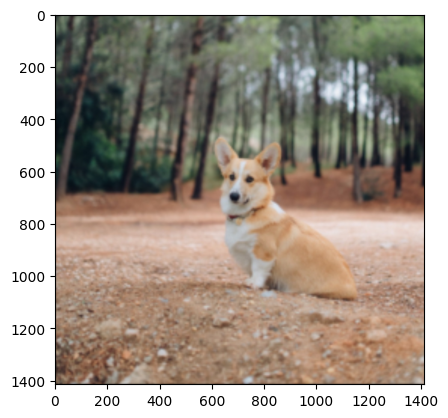

In [27]:
from torchvision.io import read_image
from torchvision.transforms import v2

img = read_image('dog1.jpg', ImageReadMode.RGB)
show(img)

## Visualizing bounding boxes
We can use :func:`~torchvision.utils.draw_bounding_boxes` to draw boxes on an
image. We can set the colors, labels, width as well as font and font size.
The boxes are in ``(xmin, ymin, xmax, ymax)`` format.



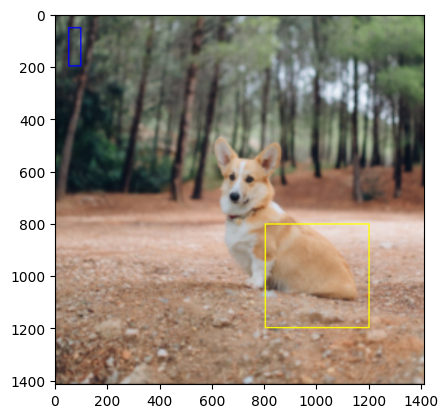

In [28]:
from torchvision.utils import draw_bounding_boxes


boxes = torch.tensor([[50, 50, 100, 200], [800, 800, 1200, 1200]], dtype=torch.float)
colors = ["blue", "yellow"]
result = draw_bounding_boxes(img, boxes, colors=colors, width=5)
show(result)

Naturally, we can also plot bounding boxes produced by torchvision detection
models.  Here is a demo with a Faster R-CNN model loaded from
:func:`~torchvision.models.detection.fasterrcnn_resnet50_fpn`
model. For more details on the output of such models, you may
refer to `instance_seg_output`.



In [36]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights


weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
transforms = weights.transforms()

v2.functional.convert_image_dtype(img, dtype=torch.float)
img_list = [img]
images = [transforms(d) for d in img_list]

model = fasterrcnn_resnet50_fpn(weights=weights, progress=False)
model = model.eval()

outputs = model(images)
print(outputs)

[{'boxes': tensor([[ 618.8422,  479.3547, 1159.5845, 1072.9478],
        [ 977.9046,  482.0297, 1015.5416,  625.8850]],
       grad_fn=<StackBackward0>), 'labels': tensor([18,  1]), 'scores': tensor([0.9992, 0.1370], grad_fn=<IndexBackward0>)}]


Let's plot the boxes detected by our model. We will only plot the boxes with a
score greater than a given threshold.



In [38]:
score_threshold = .8
imgs_with_boxes = [
    draw_bounding_boxes(img, boxes=output['boxes'][output['scores'] > score_threshold], width=4) for img, output in zip(images, outputs)
    ]
show(imgs_with_boxes)

ValueError: Tensor uint8 expected, got torch.float32

## Visualizing segmentation masks
The :func:`~torchvision.utils.draw_segmentation_masks` function can be used to
draw segmentation masks on images. Semantic segmentation and instance
segmentation models have different outputs, so we will treat each
independently.





### Instance segmentation models

Instance segmentation models have a significantly different output from the
semantic segmentation models. We will see here how to plot the masks for such
models. Let's start by analyzing the output of a Mask-RCNN model. Note that
these models don't require the images to be normalized, so we don't need to
use the normalized batch.

<div class="alert alert-info"><h4>Note</h4><p>We will here describe the output of a Mask-RCNN model. The models in
    `object_det_inst_seg_pers_keypoint_det` all have a similar output
    format, but some of them may have extra info like keypoints for
    :func:`~torchvision.models.detection.keypointrcnn_resnet50_fpn`, and some
    of them may not have masks, like
    :func:`~torchvision.models.detection.fasterrcnn_resnet50_fpn`.</p></div>



In [35]:
from torchvision.models.detection import maskrcnn_resnet50_fpn, MaskRCNN_ResNet50_FPN_Weights
from torchvision.utils import draw_segmentation_masks

weights = MaskRCNN_ResNet50_FPN_Weights.DEFAULT
transforms = weights.transforms()
v2.functional.convert_image_dtype(img, dtype=torch.float)
img_list = [img]
images = [transforms(d) for d in img_list]

model = maskrcnn_resnet50_fpn(weights=weights, progress=False)
model = model.eval()

output = model(images)
print(output)

[{'boxes': tensor([[ 616.8343,  468.4528, 1146.8038, 1087.0956],
        [ 976.1754,  478.2924, 1016.9983,  626.1592]],
       grad_fn=<StackBackward0>), 'labels': tensor([18,  1]), 'scores': tensor([0.9992, 0.5433], grad_fn=<IndexBackward0>), 'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]], grad_fn=<UnsqueezeBackward0>)}]


Let's break this down. For each image in the batch, the model outputs some
detections (or instances). The number of detections varies for each input
image. Each instance is described by its bounding box, its label, its score
and its mask.

The way the output is organized is as follows: the output is a list of length
``batch_size``. Each entry in the list corresponds to an input image, and it
is a dict with keys 'boxes', 'labels', 'scores', and 'masks'. Each value
associated to those keys has ``num_instances`` elements in it.  In our case
above there are 3 instances detected in the first image, and 2 instances in
the second one.

The boxes can be plotted with :func:`~torchvision.utils.draw_bounding_boxes`
as above, but here we're more interested in the masks. These masks are quite
different from the masks that we saw above for the semantic segmentation
models.



- マスクから特定のクラスのみ取り出す仕組みの理解
- pycocotoolsでmAPを出すためのinputを確認
- そのinputをモデルのoutputから作る

In [39]:
dog1_output = output[0]
dog1_masks = dog1_output['masks']
print(f"shape = {dog1_masks.shape}, dtype = {dog1_masks.dtype}, "
      f"min = {dog1_masks.min()}, max = {dog1_masks.max()}")

shape = torch.Size([2, 1, 1414, 1412]), dtype = torch.float32, min = 0.0, max = 0.9999865889549255


Here the masks correspond to probabilities indicating, for each pixel, how
likely it is to belong to the predicted label of that instance. Those
predicted labels correspond to the 'labels' element in the same output dict.
Let's see which labels were predicted for the instances of the first image.



In [40]:
print("For the first dog, the following instances were detected:")
print([weights.meta["categories"][label] for label in dog1_output['labels']])

For the first dog, the following instances were detected:
['dog', 'person']


Interestingly, the model detects two persons in the image. Let's go ahead and
plot those masks. Since :func:`~torchvision.utils.draw_segmentation_masks`
expects boolean masks, we need to convert those probabilities into boolean
values. Remember that the semantic of those masks is "How likely is this pixel
to belong to the predicted class?". As a result, a natural way of converting
those masks into boolean values is to threshold them with the 0.5 probability
(one could also choose a different threshold).



In [7]:
proba_threshold = 0.5
dog1_bool_masks = dog1_output['masks'] > proba_threshold
print(f"shape = {dog1_bool_masks.shape}, dtype = {dog1_bool_masks.dtype}")
dog1_bool_masks

shape = torch.Size([2, 1, 1414, 1412]), dtype = torch.bool


tensor([[[[False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          ...,
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False]]],


        [[[False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          ...,
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False]]]])

shape = torch.Size([2, 1414, 1412]), dtype = torch.bool


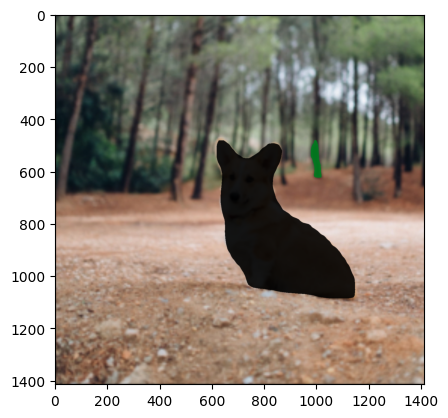

In [9]:
# There's an extra dimension (1) . We need to remove it
dog1_bool_masks = dog1_bool_masks.squeeze(1)
print(f"shape = {dog1_bool_masks.shape}, dtype = {dog1_bool_masks.dtype}")
show(draw_segmentation_masks(dog1_int, dog1_bool_masks, alpha=0.9))

The model seems to have properly detected the dog, but it also confused trees
with people. Looking more closely at the scores will help us plot more
relevant masks:



In [10]:
print(dog1_output['scores'])

tensor([0.9992, 0.5433], grad_fn=<IndexBackward0>)


Clearly the model is more confident about the dog detection than it is about
the people detections. That's good news. When plotting the masks, we can ask
for only those that have a good score. Let's use a score threshold of .75
here, and also plot the masks of the second dog.



In [ ]:
score_threshold = .75

boolean_masks = [
    out['masks'][out['scores'] > score_threshold] > proba_threshold
    for out in output
]

dogs_with_masks = [
    draw_segmentation_masks(img, mask.squeeze(1))
    for img, mask in zip(dog_list, boolean_masks)
]
show(dogs_with_masks)

The two 'people' masks in the first image where not selected because they have
a lower score than the score threshold. Similarly, in the second image, the
instance with class 15 (which corresponds to 'bench') was not selected.

